In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
# setup data loading
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 286310.72it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
# load model
model_name = "flowfa"
d_latent = 3
sample_transform = "learned6"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa(dataloaders, random_seed, **model_config)

In [7]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

# get the indices of the first ten repeated samples
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
# sanity check to see if the wanted samples transform is actually loaded
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Affine(
      init_t=Parameter containing:
      tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0.,

In [9]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 5732.356445).


100%|██████████| 70/70 [00:05<00:00, 12.99it/s]


Epoch 1/500 | train loss: 4216.112793 | val loss: -9350.431641
Score improved (5732.356445 --> -9350.431641).


100%|██████████| 70/70 [00:05<00:00, 13.27it/s]


Epoch 2/500 | train loss: -9403.088867 | val loss: 5682.290527
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 3/500 | train loss: 5760.531738 | val loss: 2137.811035
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 4/500 | train loss: 2231.903076 | val loss: 1653.948608
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 5/500 | train loss: 1744.484863 | val loss: 1288.597168
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 6/500 | train loss: 1373.560547 | val loss: 982.097961
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 7/500 | train loss: 1067.933472 | val loss: 919.312622
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 8/500 | train loss: 1007.170654 | val loss: 816.045532
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.06it/s]


Epoch 9/500 | train loss: 901.633972 | val loss: 963.687317
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 10/500 | train loss: 1097.801392 | val loss: 800.853271
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 11/500 | train loss: 1248.092529 | val loss: 856.599854
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 12/500 | train loss: 1251.315552 | val loss: 1342.311157
EarlyStopping counter: 11 out of 50
Epoch    12: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:05<00:00, 13.62it/s]


Epoch 13/500 | train loss: -9540.569336 | val loss: -12047.517578
Score improved (-9350.431641 --> -12047.517578).
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.63it/s]


Epoch 14/500 | train loss: -12176.205078 | val loss: -13020.585938
Score improved (-12047.517578 --> -13020.585938).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 15/500 | train loss: -12802.777344 | val loss: -13265.269531
Score improved (-13020.585938 --> -13265.269531).


100%|██████████| 70/70 [00:05<00:00, 13.31it/s]


Epoch 16/500 | train loss: -13706.846680 | val loss: -13376.326172
Score improved (-13265.269531 --> -13376.326172).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 17/500 | train loss: -13507.737305 | val loss: -13438.496094
Score improved (-13376.326172 --> -13438.496094).


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 18/500 | train loss: -13608.329102 | val loss: -13477.017578
Score improved (-13438.496094 --> -13477.017578).


100%|██████████| 70/70 [00:05<00:00, 13.18it/s]


Epoch 19/500 | train loss: -13828.645508 | val loss: -13503.424805
Score improved (-13477.017578 --> -13503.424805).


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 20/500 | train loss: -13745.472656 | val loss: -13522.208008
Score improved (-13503.424805 --> -13522.208008).


100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


Epoch 21/500 | train loss: -13862.525391 | val loss: -13539.179688
Score improved (-13522.208008 --> -13539.179688).


100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


Epoch 22/500 | train loss: -13923.415039 | val loss: -13549.849609
Score improved (-13539.179688 --> -13549.849609).


100%|██████████| 70/70 [00:05<00:00, 13.65it/s]


Epoch 23/500 | train loss: -14168.653320 | val loss: -13556.171875
Score improved (-13549.849609 --> -13556.171875).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 24/500 | train loss: -14013.895508 | val loss: -13566.476562
Score improved (-13556.171875 --> -13566.476562).


100%|██████████| 70/70 [00:05<00:00, 13.68it/s]


Epoch 25/500 | train loss: -13528.190430 | val loss: -13571.167969
Score improved (-13566.476562 --> -13571.167969).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 26/500 | train loss: -13959.185547 | val loss: -13576.634766
Score improved (-13571.167969 --> -13576.634766).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 27/500 | train loss: -13831.696289 | val loss: -13579.677734
Score improved (-13576.634766 --> -13579.677734).


100%|██████████| 70/70 [00:05<00:00, 13.63it/s]


Epoch 28/500 | train loss: -13849.731445 | val loss: -13586.959961
Score improved (-13579.677734 --> -13586.959961).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 29/500 | train loss: -13599.500977 | val loss: -13593.972656
Score improved (-13586.959961 --> -13593.972656).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 30/500 | train loss: -13729.341797 | val loss: -13600.765625
Score improved (-13593.972656 --> -13600.765625).


100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


Epoch 31/500 | train loss: -13872.197266 | val loss: -13611.772461
Score improved (-13600.765625 --> -13611.772461).


100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


Epoch 32/500 | train loss: -13843.814453 | val loss: -13618.562500
Score improved (-13611.772461 --> -13618.562500).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 33/500 | train loss: -13982.342773 | val loss: -13626.437500
Score improved (-13618.562500 --> -13626.437500).


100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


Epoch 34/500 | train loss: -13981.401367 | val loss: -13637.791992
Score improved (-13626.437500 --> -13637.791992).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 35/500 | train loss: -13831.330078 | val loss: -13648.415039
Score improved (-13637.791992 --> -13648.415039).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 36/500 | train loss: -13748.020508 | val loss: -13656.421875
Score improved (-13648.415039 --> -13656.421875).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 37/500 | train loss: -14067.737305 | val loss: -13665.045898
Score improved (-13656.421875 --> -13665.045898).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 38/500 | train loss: -13660.121094 | val loss: -13672.983398
Score improved (-13665.045898 --> -13672.983398).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 39/500 | train loss: -13886.835938 | val loss: -13677.306641
Score improved (-13672.983398 --> -13677.306641).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 40/500 | train loss: -13899.133789 | val loss: -13685.521484
Score improved (-13677.306641 --> -13685.521484).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 41/500 | train loss: -13567.359375 | val loss: -13691.007812
Score improved (-13685.521484 --> -13691.007812).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 42/500 | train loss: -14139.247070 | val loss: -13694.640625
Score improved (-13691.007812 --> -13694.640625).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 43/500 | train loss: -13874.235352 | val loss: -13702.206055
Score improved (-13694.640625 --> -13702.206055).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 44/500 | train loss: -13625.549805 | val loss: -13705.611328
Score improved (-13702.206055 --> -13705.611328).


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 45/500 | train loss: -13931.787109 | val loss: -13709.468750
Score improved (-13705.611328 --> -13709.468750).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 46/500 | train loss: -13980.783203 | val loss: -13714.089844
Score improved (-13709.468750 --> -13714.089844).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 47/500 | train loss: -13979.711914 | val loss: -13718.593750
Score improved (-13714.089844 --> -13718.593750).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 48/500 | train loss: -14067.922852 | val loss: -13721.647461
Score improved (-13718.593750 --> -13721.647461).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 49/500 | train loss: -13824.786133 | val loss: -13722.020508
Score improved (-13721.647461 --> -13722.020508).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 50/500 | train loss: -14003.878906 | val loss: -13727.481445
Score improved (-13722.020508 --> -13727.481445).


100%|██████████| 70/70 [00:05<00:00, 13.61it/s]


Epoch 51/500 | train loss: -13460.976562 | val loss: -13731.005859
Score improved (-13727.481445 --> -13731.005859).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 52/500 | train loss: -13850.721680 | val loss: -13734.086914
Score improved (-13731.005859 --> -13734.086914).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 53/500 | train loss: -14128.526367 | val loss: -13735.457031
Score improved (-13734.086914 --> -13735.457031).


100%|██████████| 70/70 [00:05<00:00, 13.62it/s]


Epoch 54/500 | train loss: -13918.378906 | val loss: -13739.195312
Score improved (-13735.457031 --> -13739.195312).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 55/500 | train loss: -14024.514648 | val loss: -13741.664062
Score improved (-13739.195312 --> -13741.664062).


100%|██████████| 70/70 [00:05<00:00, 13.59it/s]


Epoch 56/500 | train loss: -13968.648438 | val loss: -13744.733398
Score improved (-13741.664062 --> -13744.733398).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 57/500 | train loss: -14100.014648 | val loss: -13746.044922
Score improved (-13744.733398 --> -13746.044922).


100%|██████████| 70/70 [00:05<00:00, 13.29it/s]


Epoch 58/500 | train loss: -14133.674805 | val loss: -13749.636719
Score improved (-13746.044922 --> -13749.636719).


100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


Epoch 59/500 | train loss: -14017.585938 | val loss: -13750.239258
Score improved (-13749.636719 --> -13750.239258).


100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


Epoch 60/500 | train loss: -14162.792969 | val loss: -13751.087891
Score improved (-13750.239258 --> -13751.087891).


100%|██████████| 70/70 [00:05<00:00, 13.51it/s]


Epoch 61/500 | train loss: -13896.439453 | val loss: -13755.125000
Score improved (-13751.087891 --> -13755.125000).


100%|██████████| 70/70 [00:05<00:00, 13.15it/s]


Epoch 62/500 | train loss: -13848.066406 | val loss: -13753.275391
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.16it/s]


Epoch 63/500 | train loss: -14038.473633 | val loss: -13756.003906
Score improved (-13755.125000 --> -13756.003906).


100%|██████████| 70/70 [00:05<00:00, 13.49it/s]


Epoch 64/500 | train loss: -14034.753906 | val loss: -13759.931641
Score improved (-13756.003906 --> -13759.931641).


100%|██████████| 70/70 [00:05<00:00, 13.49it/s]


Epoch 65/500 | train loss: -13868.774414 | val loss: -13760.908203
Score improved (-13759.931641 --> -13760.908203).


100%|██████████| 70/70 [00:05<00:00, 13.50it/s]


Epoch 66/500 | train loss: -14144.647461 | val loss: -13763.005859
Score improved (-13760.908203 --> -13763.005859).


100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


Epoch 67/500 | train loss: -14254.471680 | val loss: -13763.521484
Score improved (-13763.005859 --> -13763.521484).


100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


Epoch 68/500 | train loss: -14182.555664 | val loss: -13765.443359
Score improved (-13763.521484 --> -13765.443359).


100%|██████████| 70/70 [00:05<00:00, 13.51it/s]


Epoch 69/500 | train loss: -13997.861328 | val loss: -13766.207031
Score improved (-13765.443359 --> -13766.207031).


100%|██████████| 70/70 [00:05<00:00, 13.50it/s]


Epoch 70/500 | train loss: -13795.178711 | val loss: -13767.851562
Score improved (-13766.207031 --> -13767.851562).


100%|██████████| 70/70 [00:05<00:00, 13.47it/s]


Epoch 71/500 | train loss: -13797.318359 | val loss: -13768.581055
Score improved (-13767.851562 --> -13768.581055).


100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


Epoch 72/500 | train loss: -13905.284180 | val loss: -13771.167969
Score improved (-13768.581055 --> -13771.167969).


100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


Epoch 73/500 | train loss: -14004.390625 | val loss: -13770.818359
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.46it/s]


Epoch 74/500 | train loss: -13916.317383 | val loss: -13771.421875
Score improved (-13771.167969 --> -13771.421875).


100%|██████████| 70/70 [00:05<00:00, 13.47it/s]


Epoch 75/500 | train loss: -13667.607422 | val loss: -13771.314453
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


Epoch 76/500 | train loss: -14139.917969 | val loss: -13775.244141
Score improved (-13771.421875 --> -13775.244141).


100%|██████████| 70/70 [00:05<00:00, 13.50it/s]


Epoch 77/500 | train loss: -13835.762695 | val loss: -13774.542969
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.19it/s]


Epoch 78/500 | train loss: -13871.130859 | val loss: -13777.644531
Score improved (-13775.244141 --> -13777.644531).


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 79/500 | train loss: -13991.736328 | val loss: -13776.568359
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.21it/s]


Epoch 80/500 | train loss: -13742.143555 | val loss: -13776.812500
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.26it/s]


Epoch 81/500 | train loss: -13995.244141 | val loss: -13782.995117
Score improved (-13777.644531 --> -13782.995117).


100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


Epoch 82/500 | train loss: -13781.521484 | val loss: -13780.707031
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.25it/s]


Epoch 83/500 | train loss: -13651.223633 | val loss: -13780.228516
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


Epoch 84/500 | train loss: -13868.364258 | val loss: -13781.783203
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.24it/s]


Epoch 85/500 | train loss: -14009.553711 | val loss: -13783.134766
Score improved (-13782.995117 --> -13783.134766).


100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


Epoch 86/500 | train loss: -14135.600586 | val loss: -13783.189453
Score improved (-13783.134766 --> -13783.189453).


100%|██████████| 70/70 [00:04<00:00, 14.23it/s]


Epoch 87/500 | train loss: -14022.177734 | val loss: -13784.838867
Score improved (-13783.189453 --> -13784.838867).


100%|██████████| 70/70 [00:03<00:00, 18.38it/s]


Epoch 88/500 | train loss: -14256.261719 | val loss: -13782.291016
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.82it/s]


Epoch 89/500 | train loss: -13985.282227 | val loss: -13786.167969
Score improved (-13784.838867 --> -13786.167969).


100%|██████████| 70/70 [00:03<00:00, 20.79it/s]


Epoch 90/500 | train loss: -14103.717773 | val loss: -13778.785156
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.80it/s]


Epoch 91/500 | train loss: -14495.125977 | val loss: -13785.753906
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.80it/s]


Epoch 92/500 | train loss: -13701.582031 | val loss: -13782.043945
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.79it/s]


Epoch 93/500 | train loss: -13917.625977 | val loss: -13784.037109
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.81it/s]


Epoch 94/500 | train loss: -13972.302734 | val loss: -13788.025391
Score improved (-13786.167969 --> -13788.025391).


100%|██████████| 70/70 [00:03<00:00, 20.88it/s]


Epoch 95/500 | train loss: -13788.838867 | val loss: -13789.369141
Score improved (-13788.025391 --> -13789.369141).


100%|██████████| 70/70 [00:03<00:00, 20.90it/s]


Epoch 96/500 | train loss: -14222.342773 | val loss: -13789.330078
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.91it/s]


Epoch 97/500 | train loss: -13830.727539 | val loss: -13791.800781
Score improved (-13789.369141 --> -13791.800781).


100%|██████████| 70/70 [00:03<00:00, 20.92it/s]


Epoch 98/500 | train loss: -13940.216797 | val loss: -13780.886719
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.82it/s]


Epoch 99/500 | train loss: -13980.506836 | val loss: -13785.462891
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:04<00:00, 16.69it/s]


Epoch 100/500 | train loss: -14009.588867 | val loss: -13788.353516
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 101/500 | train loss: -13963.013672 | val loss: -13810.943359
Score improved (-13791.800781 --> -13810.943359).


100%|██████████| 70/70 [00:05<00:00, 13.10it/s]


Epoch 102/500 | train loss: -14031.019531 | val loss: -13801.382812
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 103/500 | train loss: -14146.579102 | val loss: -13796.308594
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 104/500 | train loss: -14222.666992 | val loss: -13796.224609
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.14it/s]


Epoch 105/500 | train loss: -14098.188477 | val loss: -13798.894531
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 106/500 | train loss: -14300.427734 | val loss: -13787.792969
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 107/500 | train loss: -13985.918945 | val loss: -13793.597656
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 108/500 | train loss: -14165.899414 | val loss: -13795.451172
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 109/500 | train loss: -14079.244141 | val loss: -13813.301758
Score improved (-13810.943359 --> -13813.301758).


100%|██████████| 70/70 [00:05<00:00, 13.15it/s]


Epoch 110/500 | train loss: -14033.119141 | val loss: -13799.203125
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 111/500 | train loss: -14057.457031 | val loss: -13794.183594
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 112/500 | train loss: -13893.149414 | val loss: -13786.125000
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.10it/s]


Epoch 113/500 | train loss: -13910.763672 | val loss: -13780.467773
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.00it/s]


Epoch 114/500 | train loss: -13951.630859 | val loss: -13786.781250
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 115/500 | train loss: -13985.266602 | val loss: -13770.931641
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.00it/s]


Epoch 116/500 | train loss: -13989.274414 | val loss: -13771.570312
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.79it/s]


Epoch 117/500 | train loss: -14216.370117 | val loss: -13776.498047
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.18it/s]


Epoch 118/500 | train loss: -14016.672852 | val loss: -13763.178711
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 119/500 | train loss: -14139.278320 | val loss: -13802.934570
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.16it/s]


Epoch 120/500 | train loss: -13868.146484 | val loss: -13778.319336
EarlyStopping counter: 11 out of 50
Epoch   120: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 12.72it/s]


Epoch 121/500 | train loss: -14088.959961 | val loss: -13791.839844
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.19it/s]


Epoch 122/500 | train loss: -14112.454102 | val loss: -13801.234375
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 123/500 | train loss: -14238.175781 | val loss: -13814.958008
Score improved (-13813.301758 --> -13814.958008).


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 124/500 | train loss: -14074.538086 | val loss: -13804.158203
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 125/500 | train loss: -14079.522461 | val loss: -13799.041992
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 126/500 | train loss: -13913.893555 | val loss: -13802.804688
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.10it/s]


Epoch 127/500 | train loss: -13853.934570 | val loss: -13792.560547
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 128/500 | train loss: -14468.707031 | val loss: -13802.662109
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 129/500 | train loss: -14075.294922 | val loss: -13796.906250
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 130/500 | train loss: -14004.166016 | val loss: -13786.748047
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 131/500 | train loss: -13915.066406 | val loss: -13788.511719
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.03it/s]


Epoch 132/500 | train loss: -14134.179688 | val loss: -13792.429688
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.98it/s]


Epoch 133/500 | train loss: -13797.314453 | val loss: -13819.148438
Score improved (-13814.958008 --> -13819.148438).


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 134/500 | train loss: -14163.299805 | val loss: -13826.960938
Score improved (-13819.148438 --> -13826.960938).


100%|██████████| 70/70 [00:05<00:00, 13.05it/s]


Epoch 135/500 | train loss: -14283.573242 | val loss: -13816.942383
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.14it/s]


Epoch 136/500 | train loss: -14009.389648 | val loss: -13816.333984
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.52it/s]


Epoch 137/500 | train loss: -14296.346680 | val loss: -13809.312500
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 11.84it/s]


Epoch 138/500 | train loss: -14038.659180 | val loss: -13786.812500
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.90it/s]


Epoch 139/500 | train loss: -14247.512695 | val loss: -13777.710938
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.51it/s]


Epoch 140/500 | train loss: -14385.076172 | val loss: -13809.576172
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.06it/s]


Epoch 141/500 | train loss: -13738.133789 | val loss: -13808.704102
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.01it/s]


Epoch 142/500 | train loss: -13960.673828 | val loss: -13796.044922
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 143/500 | train loss: -14344.833008 | val loss: -13822.613281
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.05it/s]


Epoch 144/500 | train loss: -13742.702148 | val loss: -13803.669922
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.40it/s]


Epoch 145/500 | train loss: -14047.455078 | val loss: -13790.559570
EarlyStopping counter: 11 out of 50
Epoch   145: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 12.40it/s]


Epoch 146/500 | train loss: -13762.668945 | val loss: -13785.246094
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.08it/s]


Epoch 147/500 | train loss: -14114.461914 | val loss: -13822.666016
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 148/500 | train loss: -14127.804688 | val loss: -13809.936523
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.05it/s]


Epoch 149/500 | train loss: -14247.543945 | val loss: -13801.117188
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.90it/s]


Epoch 150/500 | train loss: -13891.876953 | val loss: -13836.282227
Score improved (-13826.960938 --> -13836.282227).


100%|██████████| 70/70 [00:05<00:00, 13.08it/s]


Epoch 151/500 | train loss: -14173.793945 | val loss: -13799.523438
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.01it/s]


Epoch 152/500 | train loss: -13956.650391 | val loss: -13799.257812
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.17it/s]


Epoch 153/500 | train loss: -14274.062500 | val loss: -13813.725586
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 154/500 | train loss: -13922.277344 | val loss: -13828.726562
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.26it/s]


Epoch 155/500 | train loss: -14294.393555 | val loss: -13818.507812
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 156/500 | train loss: -14064.338867 | val loss: -13809.294922
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 157/500 | train loss: -13879.805664 | val loss: -13792.576172
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 158/500 | train loss: -13951.893555 | val loss: -13805.687500
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 159/500 | train loss: -14020.417969 | val loss: -13828.189453
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 160/500 | train loss: -14308.254883 | val loss: -13805.224609
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 161/500 | train loss: -14113.038086 | val loss: -13814.056641
EarlyStopping counter: 11 out of 50
Epoch   161: reducing learning rate of group 0 to 1.3500e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.09it/s]


Epoch 162/500 | train loss: -14360.226562 | val loss: -13796.261719
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.08it/s]


Epoch 163/500 | train loss: -14001.703125 | val loss: -13796.191406
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.13it/s]


Epoch 164/500 | train loss: -14294.957031 | val loss: -13792.755859
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.12it/s]


Epoch 165/500 | train loss: -14019.715820 | val loss: -13814.046875
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.17it/s]


Epoch 166/500 | train loss: -13800.077148 | val loss: -13801.646484
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.01it/s]


Epoch 167/500 | train loss: -14079.650391 | val loss: -13813.337891
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 168/500 | train loss: -14100.438477 | val loss: -13818.820312
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.05it/s]


Epoch 169/500 | train loss: -14043.669922 | val loss: -13818.593750
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.08it/s]


Epoch 170/500 | train loss: -14259.605469 | val loss: -13834.393555
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.06it/s]


Epoch 171/500 | train loss: -14242.421875 | val loss: -13810.404297
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:04<00:00, 15.58it/s]


Epoch 172/500 | train loss: -13974.260742 | val loss: -13799.414062
EarlyStopping counter: 22 out of 50
Epoch   172: reducing learning rate of group 0 to 4.0500e-05.
Retrieve best model..


100%|██████████| 70/70 [00:04<00:00, 16.85it/s]


Epoch 173/500 | train loss: -14358.791016 | val loss: -13805.490234
EarlyStopping counter: 23 out of 50


100%|██████████| 70/70 [00:03<00:00, 17.75it/s]


Epoch 174/500 | train loss: -14033.167969 | val loss: -13824.549805
EarlyStopping counter: 24 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.74it/s]


Epoch 175/500 | train loss: -14397.953125 | val loss: -13801.583008
EarlyStopping counter: 25 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.73it/s]


Epoch 176/500 | train loss: -14106.372070 | val loss: -13812.417969
EarlyStopping counter: 26 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.75it/s]


Epoch 177/500 | train loss: -14273.316406 | val loss: -13807.000000
EarlyStopping counter: 27 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.79it/s]


Epoch 178/500 | train loss: -14290.923828 | val loss: -13792.648438
EarlyStopping counter: 28 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.77it/s]


Epoch 179/500 | train loss: -13709.037109 | val loss: -13826.750000
EarlyStopping counter: 29 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.77it/s]


Epoch 180/500 | train loss: -14097.884766 | val loss: -13794.773438
EarlyStopping counter: 30 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.73it/s]


Epoch 181/500 | train loss: -14128.700195 | val loss: -13825.454102
EarlyStopping counter: 31 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.74it/s]


Epoch 182/500 | train loss: -14342.411133 | val loss: -13808.550781
EarlyStopping counter: 32 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.74it/s]


Epoch 183/500 | train loss: -14071.642578 | val loss: -13843.878906
Score improved (-13836.282227 --> -13843.878906).


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 184/500 | train loss: -14202.550781 | val loss: -13812.350586
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:03<00:00, 18.50it/s]


Epoch 185/500 | train loss: -14137.046875 | val loss: -13812.955078
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:03<00:00, 19.12it/s]


Epoch 186/500 | train loss: -14548.079102 | val loss: -13819.909180
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.70it/s]


Epoch 187/500 | train loss: -13912.707031 | val loss: -13803.856445
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.70it/s]


Epoch 188/500 | train loss: -14188.788086 | val loss: -13788.670898
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 189/500 | train loss: -13999.970703 | val loss: -13815.683594
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.70it/s]


Epoch 190/500 | train loss: -14121.125000 | val loss: -13824.873047
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.73it/s]


Epoch 191/500 | train loss: -14321.289062 | val loss: -13804.595703
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 192/500 | train loss: -14299.240234 | val loss: -13819.560547
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.73it/s]


Epoch 193/500 | train loss: -14184.200195 | val loss: -13794.643555
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 194/500 | train loss: -14225.383789 | val loss: -13813.667969
EarlyStopping counter: 11 out of 50
Epoch   194: reducing learning rate of group 0 to 1.2150e-05.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 195/500 | train loss: -14338.720703 | val loss: -13814.738281
EarlyStopping counter: 12 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 196/500 | train loss: -14076.011719 | val loss: -13823.208984
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 197/500 | train loss: -14130.267578 | val loss: -13822.415039
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.77it/s]


Epoch 198/500 | train loss: -14159.349609 | val loss: -13814.847656
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.79it/s]


Epoch 199/500 | train loss: -14234.225586 | val loss: -13796.468750
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 200/500 | train loss: -14030.607422 | val loss: -13808.675781
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 201/500 | train loss: -14043.188477 | val loss: -13813.728516
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 202/500 | train loss: -14119.251953 | val loss: -13816.441406
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 203/500 | train loss: -14000.546875 | val loss: -13809.849609
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 204/500 | train loss: -14193.854492 | val loss: -13791.766602
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 205/500 | train loss: -13700.135742 | val loss: -13812.124023
EarlyStopping counter: 22 out of 50
Epoch   205: reducing learning rate of group 0 to 3.6450e-06.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 206/500 | train loss: -13850.041992 | val loss: -13803.123047
EarlyStopping counter: 23 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 207/500 | train loss: -14354.174805 | val loss: -13805.362305
EarlyStopping counter: 24 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 208/500 | train loss: -14457.180664 | val loss: -13818.535156
EarlyStopping counter: 25 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 209/500 | train loss: -14003.597656 | val loss: -13799.272461
EarlyStopping counter: 26 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 210/500 | train loss: -14159.842773 | val loss: -13816.875000
EarlyStopping counter: 27 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 211/500 | train loss: -13988.912109 | val loss: -13819.353516
EarlyStopping counter: 28 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 212/500 | train loss: -14119.061523 | val loss: -13783.728516
EarlyStopping counter: 29 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 213/500 | train loss: -14330.315430 | val loss: -13817.302734
EarlyStopping counter: 30 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 214/500 | train loss: -14154.933594 | val loss: -13803.333984
EarlyStopping counter: 31 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 215/500 | train loss: -13837.573242 | val loss: -13813.422852
EarlyStopping counter: 32 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.72it/s]


Epoch 216/500 | train loss: -13931.123047 | val loss: -13807.208984
EarlyStopping counter: 33 out of 50
Epoch   216: reducing learning rate of group 0 to 1.0935e-06.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


Epoch 217/500 | train loss: -13988.636719 | val loss: -13805.257812
EarlyStopping counter: 34 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.70it/s]


Epoch 218/500 | train loss: -14428.195312 | val loss: -13804.501953
EarlyStopping counter: 35 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 219/500 | train loss: -14175.167969 | val loss: -13839.124023
EarlyStopping counter: 36 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 220/500 | train loss: -14382.987305 | val loss: -13826.677734
EarlyStopping counter: 37 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.68it/s]


Epoch 221/500 | train loss: -14190.747070 | val loss: -13834.986328
EarlyStopping counter: 38 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 222/500 | train loss: -14272.281250 | val loss: -13824.809570
EarlyStopping counter: 39 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 223/500 | train loss: -14015.804688 | val loss: -13827.031250
EarlyStopping counter: 40 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.68it/s]


Epoch 224/500 | train loss: -14120.514648 | val loss: -13823.755859
EarlyStopping counter: 41 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 225/500 | train loss: -14322.005859 | val loss: -13814.887695
EarlyStopping counter: 42 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 226/500 | train loss: -14206.291992 | val loss: -13825.167969
EarlyStopping counter: 43 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 227/500 | train loss: -14104.875977 | val loss: -13817.434570
EarlyStopping counter: 44 out of 50
Epoch   227: reducing learning rate of group 0 to 3.2805e-07.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 20.68it/s]


Epoch 228/500 | train loss: -14118.556641 | val loss: -13777.066406
EarlyStopping counter: 45 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 229/500 | train loss: -14045.156250 | val loss: -13806.230469
EarlyStopping counter: 46 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 230/500 | train loss: -13926.119141 | val loss: -13802.386719
EarlyStopping counter: 47 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 231/500 | train loss: -14002.126953 | val loss: -13799.744141
EarlyStopping counter: 48 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.69it/s]


Epoch 232/500 | train loss: -14036.655273 | val loss: -13800.526367
EarlyStopping counter: 49 out of 50


100%|██████████| 70/70 [00:03<00:00, 20.68it/s]


Epoch 233/500 | train loss: -13883.238281 | val loss: -13827.279297
EarlyStopping counter: 50 out of 50
Early stopping at epoch 232. Best val loss: -13843.879
Retrieve best model..


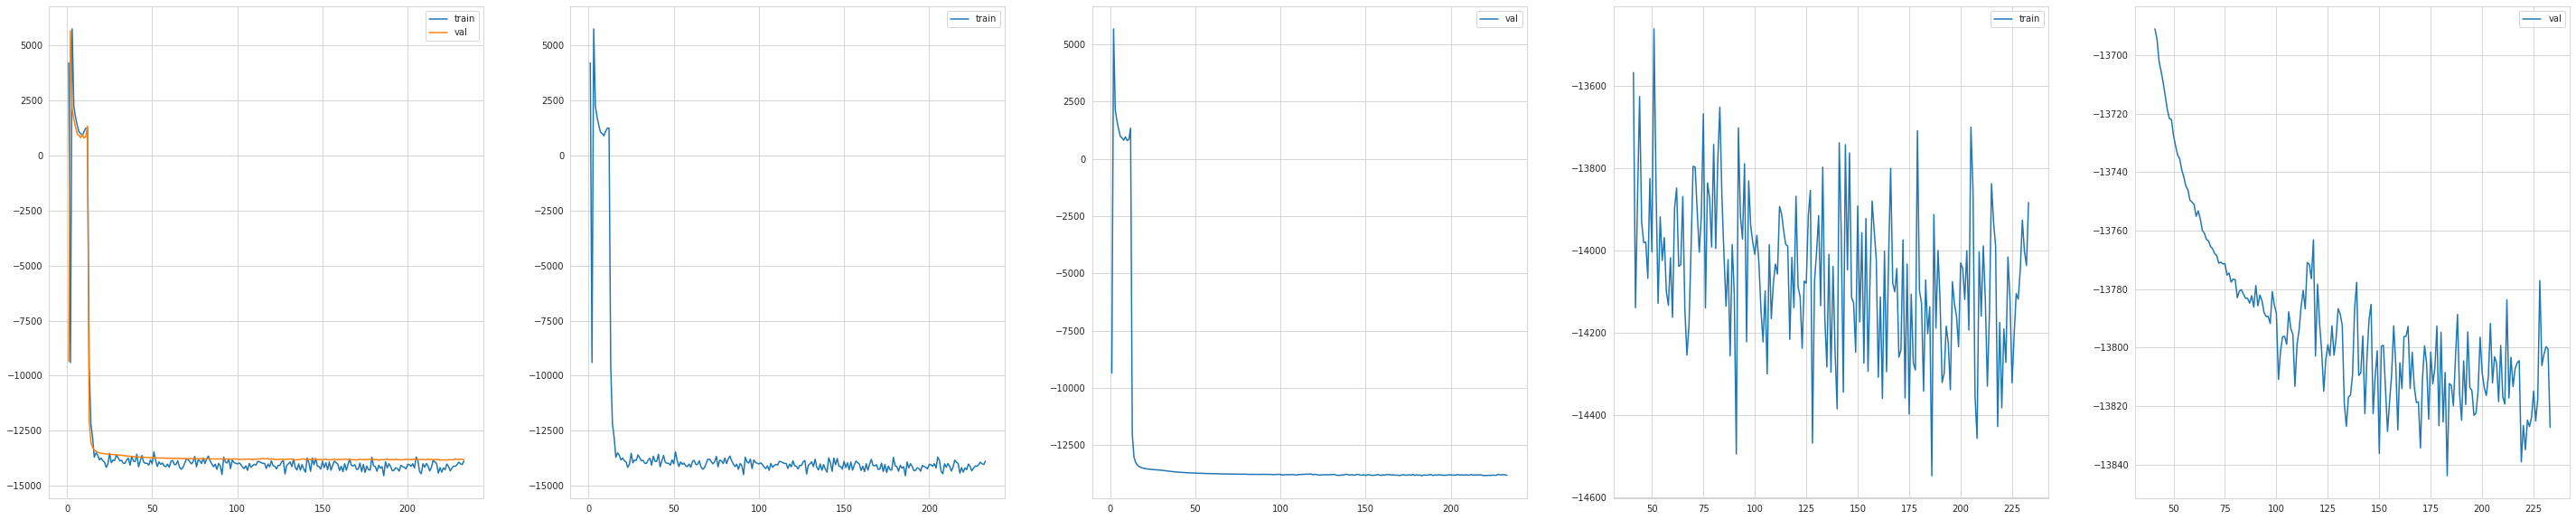

In [10]:
# plot training losses if we trained (additional plot after 40 epochs so we can see the later values better)
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [11]:
print(model)

FlowFA(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (la

In [12]:
from utility_extended import *

In [13]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: -20.41840651055031
Val loss: -20.62140961635965
Test loss: -20.578425701722153


In [14]:
torch.save(model, "./models/FlowFA-Original")